In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

gpytorch.functions.use_toeplitz = False
gpytorch.functions.max_cg_iterations = 100

%matplotlib inline


Bad key "hatch.linewidth" on line 54 in
/home/gpleiss/.dotfiles/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_x = train_x.cuda()
train_y = train_y.cuda()

In [3]:
class GPRegressionModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPRegressionModel, self).__init__(grid_size=128, grid_bounds=[(0, 1)])
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)


model = GPRegressionModel().cuda()
likelihood = GaussianLikelihood().cuda()

In [4]:
# Optimize the model
model.train()
likelihood.train()

optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0

def train():
    for i in range(200):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/100 - Loss: %.3f' % (i + 1, loss.data[0]))
        optimizer.step()
%time train()

Iter 1/100 - Loss: 571.016
Iter 2/100 - Loss: 583.773
Iter 3/100 - Loss: 373.296
Iter 4/100 - Loss: 318.581
Iter 5/100 - Loss: 260.492
Iter 6/100 - Loss: 181.310
Iter 7/100 - Loss: 118.992
Iter 8/100 - Loss: 90.622
Iter 9/100 - Loss: 57.249
Iter 10/100 - Loss: 44.293
Iter 11/100 - Loss: 29.056
Iter 12/100 - Loss: 25.805
Iter 13/100 - Loss: 17.876
Iter 14/100 - Loss: 25.928
Iter 15/100 - Loss: 27.122
Iter 16/100 - Loss: 37.263
Iter 17/100 - Loss: 38.587
Iter 18/100 - Loss: 39.792
Iter 19/100 - Loss: 40.064
Iter 20/100 - Loss: 41.405
Iter 21/100 - Loss: 37.034
Iter 22/100 - Loss: 35.035
Iter 23/100 - Loss: 34.154
Iter 24/100 - Loss: 27.730
Iter 25/100 - Loss: 24.320
Iter 26/100 - Loss: 19.473
Iter 27/100 - Loss: 14.848
Iter 28/100 - Loss: 15.449
Iter 29/100 - Loss: 9.339
Iter 30/100 - Loss: 8.262
Iter 31/100 - Loss: 6.032
Iter 32/100 - Loss: 5.193
Iter 33/100 - Loss: 4.442
Iter 34/100 - Loss: 4.631
Iter 35/100 - Loss: 5.090
Iter 36/100 - Loss: 5.104
Iter 37/100 - Loss: 4.884
Iter 38/100 

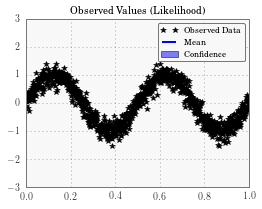

In [5]:
model.eval()
likelihood.eval()

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
test_x = Variable(torch.linspace(0, 1, 51)).cuda()
observed_pred = likelihood(model(test_x))

def ax_plot(ax, rand_var, title):
    lower, upper = rand_var.confidence_region()
    ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
    ax.plot(test_x.data.cpu().numpy(), rand_var.mean().data.cpu().numpy(), 'b')
    ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')